In [18]:
import os
import operator
from dotenv import load_dotenv
from typing import Annotated, List, Optional
from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown
from langchain_tavily import TavilySearch
import markdown2

In [19]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [20]:
llm = init_chat_model("groq:llama-3.3-70b-versatile")

tavily_tool = TavilySearch(max_results=3)

In [21]:
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.")
    description: str = Field(description="A brief overview of the main topics and concepts to be covered in this section.")

class Sections(BaseModel):
    sections: List[Section] = Field(description="The sections of the report.")


class Critique(BaseModel):
    revision_required: bool = Field(description="Whether the section requires revision.")
    feedback: str = Field(description="Constructive feedback for the writer on how to improve the section.")

class ReportState(TypedDict):
    topic: str
    sections: List[Section]
    current_section_index: int
    current_research_data: str
    draft_content: str
    feedback: Optional[str]
    revision_count: int
    completed_sections: Annotated[list, operator.add]
    final_report: str
    html_report_path: Optional[str] 


In [22]:
def orchestrator(state: ReportState):
    """Orchestrator: Creates a plan (sections) for the report."""
    print("--- RUNNING ORCHESTRATOR ---")
    planner = llm.with_structured_output(Sections)
    report_sections = planner.invoke([
        SystemMessage(content="Create a detailed and comprehensive plan for a report."),
        HumanMessage(content=f"The report topic is: {state['topic']}"),
    ])
    return {"sections": report_sections.sections}



In [23]:
def researcher(state: ReportState):
    """Researcher: Conducts a web search for the current section."""
    print("--- RUNNING RESEARCHER ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    print(f"-> Researching section: {current_section.name}")
    query = f"in-depth information on: {state['topic']} - {current_section.name}: {current_section.description}"
    search_result = tavily_tool.invoke(query)
    return {"current_research_data": search_result, "revision_count": 0}

In [24]:
def writer(state: ReportState):
    """Writer: Writes the current section, incorporating feedback if available."""
    print("--- RUNNING WRITER ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    research_data = state['current_research_data']
    feedback = state.get('feedback')

    count = state.get("revision_count", 0)

    prompt_addition = ""
    if feedback:
        print(f"-> Revising section (Attempt {count + 1}) based on feedback: {feedback}")
        prompt_addition = f"""
        IMPORTANT: You MUST revise the section based on the following feedback. 
        Prioritize these instructions over all other rules.
        REVISION FEEDBACK: {feedback}
        """
    else:
        print(f"-> Writing new draft for section: {current_section.name}")

    writer_prompt = f"""
    Write the following section in detail, using the provided research findings.
    Write only the section content, without a title and without any preamble. Use Markdown formatting.
    {prompt_addition}
    SECTION NAME: {current_section.name}
    SECTION DESCRIPTION: {current_section.description}
    RESEARCH FINDINGS TO USE:
    {research_data}
    """
    section_content = llm.invoke([
        SystemMessage(content="You are an expert report writer."),
        HumanMessage(content=writer_prompt),
    ]).content
    return {"draft_content": section_content, "revision_count": count + 1}

In [25]:
def critic(state: ReportState):
    """Critic: Reviews the draft and decides if revision is needed."""
    print("--- RUNNING CRITIC ---")
    draft = state['draft_content']
    critic_llm = llm.with_structured_output(Critique)
    
    critique_prompt = f"""
    You are an expert editor. Please review the following draft section.
    Evaluate it for clarity, accuracy, and depth.
    If the section is generally good but could be slightly better, approve it. 
    Only request a revision if there are significant errors or omissions.
    Your feedback must be concrete and actionable.

    DRAFT:
    {draft}
    """
    review: Critique = critic_llm.invoke([
        SystemMessage(content="You are an expert editor and critic."),
        HumanMessage(content=critique_prompt),
    ])

    print(f"-> Critic's decision: Revision required? {review.revision_required}")
    if review.revision_required:
        return {"feedback": review.feedback}
    else:
        return {"feedback": None}


In [26]:
def section_collector(state: ReportState):
    """Collector: Adds the approved draft to the completed sections list."""
    print("--- RUNNING COLLECTOR ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    draft_content = state['draft_content']
    
    full_section = f"## {current_section.name}\n\n{draft_content}"
    
    next_index = current_index + 1
    return {"completed_sections": [full_section], "current_section_index": next_index}


In [27]:
def synthesizer(state: ReportState):
    """Synthesizer: Combines all completed sections into the final report."""
    print("--- RUNNING SYNTHESIZER ---")
    final_report = "\n\n---\n\n".join(state["completed_sections"])
    return {"final_report": final_report}


In [28]:
MAX_REVISIONS = 3

def should_loop_for_revision(state: ReportState):
    """Decides whether to loop back to the writer or collect the section."""
    print("--- CHECKING REVISION STATUS ---")
    feedback = state.get("feedback")
    count = state.get("revision_count", 0)

    if feedback and count < MAX_REVISIONS:
        print(f"-> Revision required (Attempt {count}). Looping back to writer.")
        return "writer"  
    else:
        if count >= MAX_REVISIONS:
            print(f"-> Max revisions of {MAX_REVISIONS} reached. Accepting current draft.")
        else:
            print("-> Draft approved by critic. Moving on.")
        return "section_collector"
    


def should_continue_or_synthesize(state: ReportState):
    if state['current_section_index'] >= len(state['sections']):
        return "synthesizer" 
    else:
        return "researcher" 

In [29]:
def html_converter(state: ReportState):
    """Converts the final markdown report to a styled HTML file."""
    print("--- RUNNING HTML CONVERTER ---")
    
    # Get the final report content from the state
    markdown_report = state.get("final_report")
    if not markdown_report:
        return {}

    css_style = """
    <style>
        body {
            font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif;
            line-height: 1.6;
            color: #333;
            max-width: 800px;
            margin: 40px auto;
            padding: 20px;
            background-color: #f9f9f9;
        }
        h1, h2, h3 {
            color: #2c3e50;
            border-bottom: 2px solid #ecf0f1;
            padding-bottom: 10px;
        }
        h1 {
            font-size: 2.5em;
        }
        h2 {
            font-size: 2em;
        }
        p {
            margin-bottom: 1em;
        }
        code {
            background-color: #ecf0f1;
            padding: 2px 5px;
            border-radius: 4px;
        }
        pre {
            background-color: #2c3e50;
            color: #f8f8f2;
            padding: 15px;
            border-radius: 5px;
            overflow-x: auto;
        }
        blockquote {
            border-left: 4px solid #3498db;
            padding-left: 15px;
            color: #555;
            font-style: italic;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            margin-bottom: 1em;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
    """

    html_body = markdown2.markdown(markdown_report, extras=["tables", "fenced-code-blocks", "cuddled-lists"])

    report_title = state.get("topic", "AI Generated Report")

    full_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-g">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>{report_title}</title>
        {css_style}
    </head>
    <body>
        <h1>{report_title}</h1>
        {html_body}
    </body>
    </html>
    """

    file_path = "report.html"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(full_html)
    
    print(f"-> Report successfully saved to {file_path}")

    return {"html_report_path": file_path}

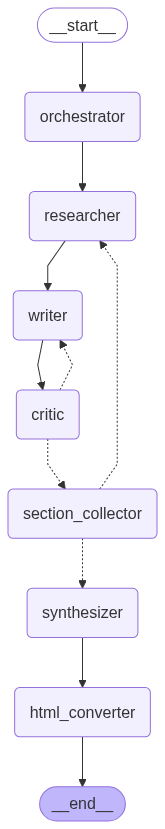

In [30]:
workflow = StateGraph(ReportState)

workflow.add_node("orchestrator", orchestrator)
workflow.add_node("researcher", researcher)
workflow.add_node("writer", writer)
workflow.add_node("critic", critic)
workflow.add_node("section_collector", section_collector)
workflow.add_node("synthesizer", synthesizer)
workflow.add_node("html_converter", html_converter) 


workflow.add_edge(START, "orchestrator")
workflow.add_edge("orchestrator", "researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", "critic")

workflow.add_conditional_edges(
    "critic",
    should_loop_for_revision,
    {"writer": "writer", "section_collector": "section_collector"}
)

workflow.add_conditional_edges(
    "section_collector",
    should_continue_or_synthesize,
    {"researcher": "researcher", "synthesizer": "synthesizer"}
)


workflow.add_edge("synthesizer", "html_converter")
workflow.add_edge("html_converter", END)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
topic = "The career of Stephen Curry and his impact on the NBA"
initial_state = {
    "topic": topic,
    "current_section_index": 0,
    "completed_sections": []
}
final_state = app.invoke(initial_state, config={"recursion_limit": 100})

Markdown(final_state["final_report"])

--- RUNNING ORCHESTRATOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Introduction
--- RUNNING WRITER ---
-> Writing new draft for section: Introduction
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Early Career
--- RUNNING WRITER ---
-> Writing new draft for section: Early Career
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Rise to Prominence
--- RUNNING WRITER ---
-> Writing new draft for section: Rise to Prominence
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RESEARCHER ---
-> Researching section:

## Introduction

### Background and Introduction to Stephen Curry
Stephen Curry is a renowned American professional basketball player, born on March 14, 1988, in Akron, Ohio. He has led the Golden State Warriors to multiple championships, including titles in 2014-15, 2016-17, 2017-18, and 2021-22. Curry's impressive career began when he was selected by the Warriors with the seventh overall pick in the 2009 NBA draft. Standing at 6 feet 2 inches tall, he has consistently demonstrated exceptional skill on the court, earning him numerous accolades, including being named the league's Most Valuable Player (MVP) in 2014-15.

### Career Highlights and Achievements
Throughout his career, Curry has achieved several notable milestones. In the 2014-15 season, he made a then-record 286 three-pointers, leading the Warriors to an NBA-best 67-15 record. His performance earned him the MVP title, and he propelled the Warriors to their first championship in 40 years, defeating the Cleveland Cavaliers in the finals. Curry's dominance continued in subsequent seasons, with the Warriors regaining their dominance and winning a fourth title during his era. He was named finals MVP after scoring 31.2 points per game during the six-game series win over the Boston Celtics.

### Purpose of the Report
This report aims to provide an in-depth analysis of Stephen Curry's career and his impact on the NBA. It will delve into his background, highlighting his early life, college career, and entry into the professional league. The report will also examine his achievements, including his multiple championships, MVP awards, and record-breaking performances. Furthermore, it will discuss Curry's influence on the game, his leadership role in the Warriors, and his legacy in the NBA. By exploring these aspects, this report seeks to provide a comprehensive understanding of Stephen Curry's remarkable career and his enduring impact on the world of basketball.

---

## Early Career

### Introduction to Early Life and College Career
Stephen Curry's early life and college career played a significant role in shaping his future as a professional basketball player. Born with a natural talent for the sport, Curry's dedication and hard work would eventually lead him to become one of the most successful players in NBA history.

### College Achievements
During his time as a college junior in 2009, Curry averaged an impressive 28.6 points per game, leading the nation and catching the attention of NBA scouts. This outstanding performance was a testament to his skill and determination, setting the stage for his future success.

### Entry into the NBA
Following his remarkable college career, Curry was selected by the Golden State Warriors with the seventh pick in the NBA draft. This marked the beginning of an extraordinary journey, as Curry would go on to achieve unprecedented success with the Warriors, including winning four NBA championships and setting multiple records throughout his career.

### Early NBA Career Highlights
In his early years with the Warriors, Curry quickly established himself as a key player, demonstrating his ability to score and assist with remarkable consistency. By the 2013-2014 season, he was averaging career highs of 24.0 points and 8.5 assists per game, making him the first player in Warriors franchise history to achieve such numbers. This impressive performance was a sign of things to come, as Curry continued to push the boundaries of what was possible on the court.

### Notable Achievements and Records
One of Curry's most notable achievements came in 2015, when he helped the Warriors win the NBA championship. The following season, he led the team to a league-record 73 wins, further cementing his status as a basketball legend. In the 2017 NBA Finals, Curry recorded his first career postseason triple-double, with 32 points, 11 assists, and 10 rebounds, showcasing his incredible versatility and skill.

### Conclusion
Stephen Curry's early career, from his college days to his entry into the NBA, was marked by remarkable achievements and a clear dedication to his craft. As he continued to grow and develop as a player, Curry would go on to achieve even greater success, leaving an indelible mark on the world of basketball.

---

## Rise to Prominence

### Early Success and Breakthrough Seasons
Stephen Curry's rise to prominence in the NBA began with his exceptional performance in college, where he led the nation with an average of 28.6 points per game as a junior in 2009. This impressive display earned him the seventh pick in the NBA draft by the Golden State Warriors. 

### Awards and Accolades
Curry's professional career has been marked by numerous awards and accolades, including being the first person to be named MVP by unanimous vote in NBA history. He has won four NBA championships with the Golden State Warriors, with the team achieving a league-record 73 wins in the 2015-2016 season. 

### Notable Seasons and Performances
One of Curry's most notable performances was in Game 5, where he scored 34 points and teammate Kevin Durant added 39 points, securing the Warriors' second NBA championship in three years with a 129-120 victory. Curry has consistently demonstrated his skill and dedication to the sport, leading the league in 3-point field goals for a third consecutive season and ranking third in overall scoring. 

### Recognition and Legacy
Throughout his career, Curry has received widespread recognition for his achievements, including being a unanimous All-NBA First Team selection. His impact on the NBA has been profound, and he continues to be celebrated as one of the greatest players in the history of the sport. With a legacy that extends beyond his on-court accomplishments, Curry has inspired countless fans and aspiring athletes around the world. 

### Continued Success and Dominance
Curry's ability to consistently perform at an elite level has cemented his status as a basketball legend. As he continues to break records and push the boundaries of what is possible on the court, his influence on the game will undoubtedly endure for generations to come. With his remarkable talent, unwavering dedication, and unrelenting passion for the sport, Stephen Curry remains an iconic figure in the world of basketball.

---

## Impact on the NBA

### Introduction to Curry's Impact
Stephen Curry has revolutionized the game of basketball, inspiring a new generation of players and redefining how the game is played. With his dedication, innovation, and self-belief, Curry has turned the game upside down, leaving a lasting impact on the NBA.

### Changes in Team Strategies
Curry's influence on the game has led to significant changes in team strategies. His ability to make three-pointers from anywhere on the court has forced teams to rethink their defensive approaches. Many teams now employ smaller, more agile lineups to counter Curry's shooting range and speed. Additionally, teams have started to focus more on outside shooting, with an emphasis on finding players who can stretch the defense with their three-point range.

### Player Development
Curry's impact on player development has been profound. He has inspired a generation of young players to focus on developing their outside shooting skills. Many players now spend countless hours in the gym, working on their three-point shots and trying to emulate Curry's shooting technique. This has led to an increase in the number of players who can shoot from beyond the arc, making the game more exciting and dynamic.

### Record-Breaking Achievements
Throughout his career, Curry has broken numerous records, including the record for most three-pointers made in a season. He has also won numerous awards, including multiple MVP awards and the NBA Clutch Player of the Year Award. His contract extension with the Warriors, worth over $200 million, set a new NBA record and cemented his status as one of the highest-paid players in the league.

### Legacy and Influence
Curry's legacy extends beyond his on-court achievements. He has inspired a new generation of players to work hard, believe in themselves, and never give up on their dreams. His influence on the game has been felt across the globe, with players from all over the world looking up to him as a role model. As one article put it, "Stephen Curry is still inevitable," a testament to his enduring impact on the game of basketball.

### Conclusion
In conclusion, Stephen Curry's impact on the NBA has been profound. He has changed the way teams approach the game, inspired a new generation of players, and broken numerous records. His legacy will continue to be felt for years to come, and his influence on the game will remain a lasting one. As the NBA continues to evolve, one thing is certain: Stephen Curry's impact will be remembered as one of the most significant in the history of the game.

---

## Championships and Legacy

### Championship Wins
Stephen Curry has won four NBA championships with the Golden State Warriors, cementing his legacy as one of the greatest players in the history of the franchise. His first championship win came in 2015, where he played a crucial role in the Warriors' victory. The following season, Curry led the team to a league-record 73 wins, showcasing his exceptional skills and leadership on the court. In 2017 and 2018, Curry and the Warriors won back-to-back championships, with Curry being named the NBA Finals MVP in 2022.

### Lasting Impact on the Golden State Warriors
Curry's impact on the Golden State Warriors extends beyond his championship wins. He has been instrumental in shaping the team's culture and identity, and his influence can be seen in the way the team plays and conducts itself on and off the court. Curry's work ethic, dedication, and passion for the game have set a high standard for his teammates, and his leadership has been a key factor in the team's success. As a result, Curry has become an iconic figure in the Warriors organization, and his number 30 jersey is likely to be retired by the team in the future.

### Legacy in the NBA
Curry's legacy extends beyond the Golden State Warriors, as he has had a profound impact on the NBA as a whole. He is widely regarded as one of the greatest shooters in NBA history, and his ability to make shots from anywhere on the court has changed the way teams defend and play offense. Curry's influence can be seen in the way teams are now built around talented shooters and playmakers, and his playing style has inspired a generation of young players. Additionally, Curry's commitment to social justice and community outreach has made him a role model off the court, and his philanthropic efforts have had a positive impact on communities around the world.

### Records and Accolades
Throughout his career, Curry has broken numerous records and achieved countless accolades. He is a two-time NBA MVP, a six-time NBA All-Star, and a four-time NBA scoring champion. Curry has also been named to the All-NBA Team multiple times and has won the NBA Three-Point Contest twice. In 2021, Curry surpassed Ray Allen's record for most three-pointers made in NBA history, cementing his status as the greatest shooter in NBA history. With his continued success on the court and his lasting impact on the game, Curry's legacy is sure to endure for generations to come.

---

## Conclusion

### Summary of Curry's Career
Stephen Curry is a professional basketball player who has had a profound impact on the NBA. Throughout his career, he has achieved numerous accolades, including being the first person to be named MVP by unanimous vote in NBA history. He has won four NBA championships with the Golden State Warriors and has led the team to a league-record 73 wins in a single season.

### Enduring Influence on the NBA
Curry's influence on the NBA extends beyond his on-court accomplishments. He has changed the way teams approach the game, with many adopting a more three-point oriented strategy. His ability to score from anywhere on the court has made him a nightmare for defenders to match up against. Additionally, his work ethic and dedication to his craft have inspired a generation of young players to follow in his footsteps.

### Career Highlights
Some of Curry's most notable career highlights include:
* Leading the nation with an average of 28.6 points per game as a college junior in 2009
* Being selected with the seventh pick of the NBA draft by the Golden State Warriors
* Scoring 34 points in Game 5 of the NBA Finals to help the Warriors win their second championship in three years
* Recording his first career postseason triple-double with 32 points, 11 assists, and 10 rebounds in Game 2 of the 2017 NBA Finals

### Legacy
As Curry continues to play at an elite level, his legacy continues to grow. He has cemented his place as one of the greatest shooters in NBA history, and his impact on the game will be felt for years to come. Despite speculation about his retirement timeline, Curry remains focused on continuing to compete at the highest level and adding to his already impressive resume. With his incredible work ethic and dedication to his craft, it's likely that Curry will remain a dominant force in the NBA for years to come.